In [32]:
## source: Qutiles-3head.ipynb from pytorch-temph

Calculate metrics: \
PICP: Prediction Interval Coverage Percent \
PINAW: Predictipon Interval Ner \
https://github.com/scikit-learn/scikit-learn/issues/20162 \
Expected calibration error 

Get heatmap \
Ordinal Regression (Classes with relative distances) \
Regression via Classification \
Get concrete results (or real data) 

calibration bandı ekle \
post hoc gaussian filter \

tempeature ile çıktıyı regulerize et \
trainingdeki labelları gaussianla smoothlaştır \




Long term goal: \
Get regions as predicted set (Segmentation-YOLO) 


In [33]:
def get_cuda_summary(memory=False):
    import torch

    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        if memory:
            print(torch.cuda.memory_summary())
    else:
        print('cuda is not available')

In [34]:
import torch
get_cuda_summary()
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.set_device(0) if torch.cuda.is_available() else None
#do not execute this if you fit auto-pytorch model

cuda is not available


In [102]:
import numpy as np
np.random.seed(42)

N = 10000
train_x = np.random.normal(0,1,(N,))
x = 3*train_x+1 # N(1,9)

# Cauchy distributed error
s = np.random.standard_cauchy(N)/2

# Laplace distribution
s = np.random.laplace(size=N)

# t-distribution
s = np.random.standard_t(df = 3, size=N)

# Normal distribution
s = np.random.normal(0, 1, N)


#xmean = np.mean(x)
#xsd = np.std(x)

# y = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 10

y1 = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 10
x1 = train_x
y2 = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 20
x2 = train_x

# y = np.concatenate((y1, y2))
# x = np.concatenate((x1, x2))
# train_x = np.concatenate((x1, x2))

y = y1
x = x1
train_x = x1

ymean = np.mean(y)
ysd = np.std(y)

xmean = np.mean(x)
xsd = np.std(x)
train_y = (y-ymean)/ysd

In [103]:
y.shape

(10000,)

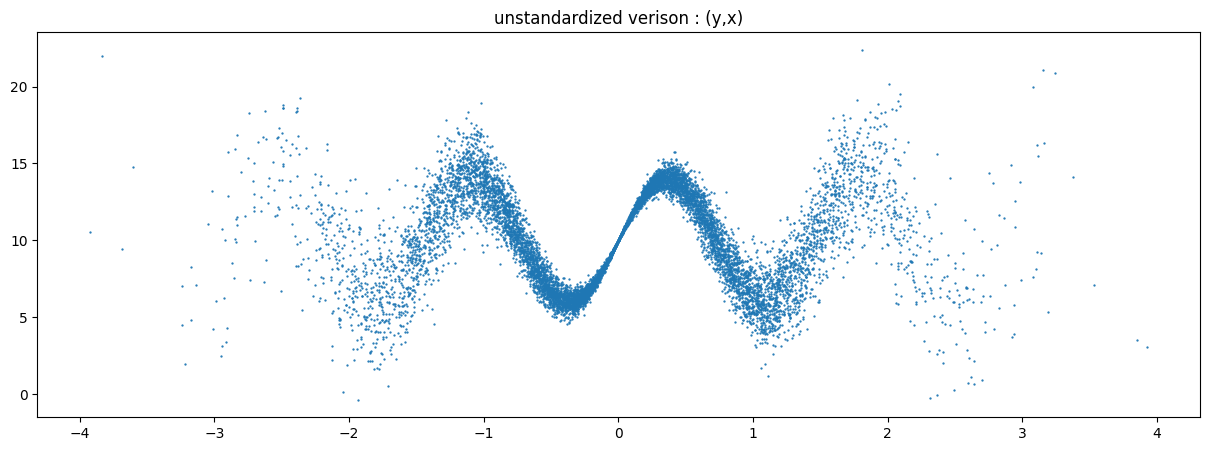

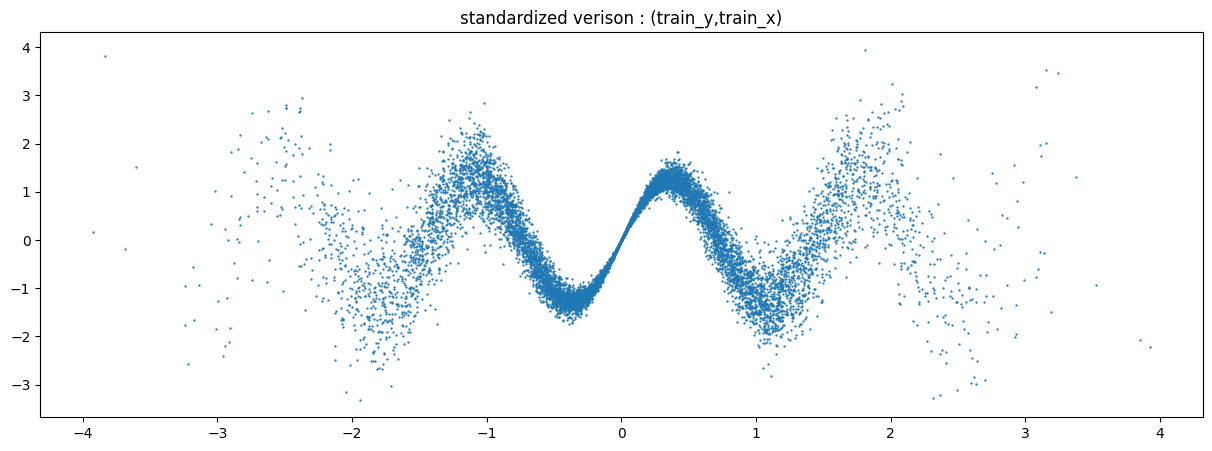

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.scatter(x, y, s=0.4)
plt.title('unstandardized verison : (y,x)')
plt.show()

plt.figure(figsize=(15,5))
plt.scatter(train_x, train_y, s=0.4)
plt.title('standardized verison : (train_y,train_x)')
plt.show()

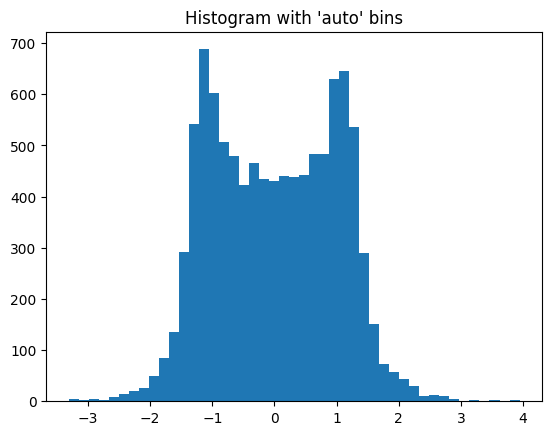

In [127]:
import pandas as pd

import torch
from torch import nn
import os
import matplotlib.pyplot as plt

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

# data = pd.read_csv('/content/02_Linear_Regression_Model_Data.csv')

hist, bin_edges, _ = plt.hist(train_y, bins='auto')  # arguments are passed to np.histogram
class_digits = np.digitize(train_y, bin_edges) # Get the class of each point using histogram bins

no_of_classes = bin_edges.shape[0]+1
one_hots = np.zeros((train_y.size, no_of_classes))
one_hots[np.arange(train_y.size), class_digits] = 1

plt.title("Histogram with 'auto' bins")
plt.show()

# Avoid copy data, just refer
train_x_tr = torch.from_numpy(train_x.reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
train_y_scalar = torch.from_numpy(train_y.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()
train_y_tr = torch.from_numpy(one_hots.reshape([-1, no_of_classes])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()

In [128]:
class QClassifier(torch.nn.Module):
    def __init__(self, in_size=1, no_of_classes=55):
        super(QClassifier,self).__init__()
        self.in_size = in_size
        self.out_size = no_of_classes

        hidden_layer = 64

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.in_size, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, hidden_layer),
            # torch.nn.Dropout(p=0.9),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, self.out_size)
            )

    def forward(self,x):
        return self.net(x)



In [129]:
train_x_tr = train_x_tr.to(device)
train_y_tr = train_y_tr.to(device)

model = QClassifier(in_size=1, no_of_classes=no_of_classes).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [130]:
for step in range(3000):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x_tr)
    loss = criterion(logits, train_y_tr)
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 1000 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1 loss=3.851
epoch 1000 loss=2.025
epoch 2000 loss=1.946
epoch 3000 loss=1.915


In [131]:
bin_edges

array([-3.31173894, -3.15051361, -2.98928828, -2.82806296, -2.66683763,
       -2.50561231, -2.34438698, -2.18316165, -2.02193633, -1.860711  ,
       -1.69948568, -1.53826035, -1.37703502, -1.2158097 , -1.05458437,
       -0.89335904, -0.73213372, -0.57090839, -0.40968307, -0.24845774,
       -0.08723241,  0.07399291,  0.23521824,  0.39644357,  0.55766889,
        0.71889422,  0.88011954,  1.04134487,  1.2025702 ,  1.36379552,
        1.52502085,  1.68624617,  1.8474715 ,  2.00869683,  2.16992215,
        2.33114748,  2.49237281,  2.65359813,  2.81482346,  2.97604878,
        3.13727411,  3.29849944,  3.45972476,  3.62095009,  3.78217542,
        3.94340074])

In [132]:
no_of_classes

47

In [133]:
bin_edges

array([-3.31173894, -3.15051361, -2.98928828, -2.82806296, -2.66683763,
       -2.50561231, -2.34438698, -2.18316165, -2.02193633, -1.860711  ,
       -1.69948568, -1.53826035, -1.37703502, -1.2158097 , -1.05458437,
       -0.89335904, -0.73213372, -0.57090839, -0.40968307, -0.24845774,
       -0.08723241,  0.07399291,  0.23521824,  0.39644357,  0.55766889,
        0.71889422,  0.88011954,  1.04134487,  1.2025702 ,  1.36379552,
        1.52502085,  1.68624617,  1.8474715 ,  2.00869683,  2.16992215,
        2.33114748,  2.49237281,  2.65359813,  2.81482346,  2.97604878,
        3.13727411,  3.29849944,  3.45972476,  3.62095009,  3.78217542,
        3.94340074])

In [134]:
min_val, max_val = bin_edges.min()-0.3, bin_edges.max()+0.3
width = 0.01

x_pred = np.arange(-4,4,width)

intervals = np.array(list(zip([min_val, *bin_edges], [*bin_edges, max_val])))
intervals.shape
bbox_x = x_pred-(width/2)
bbox_y = intervals[:,0]
bbox_w = np.array([width]*intervals.shape[0])
bbox_h = intervals[:,1] - intervals[:,0]

In [135]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [114]:
sorted_indices.shape[0]

800

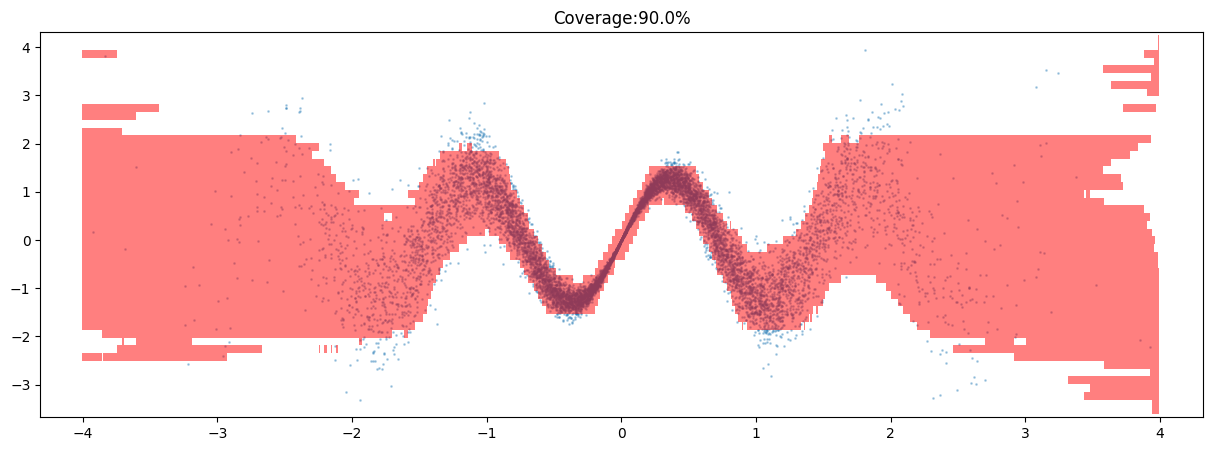

In [118]:
x_pred = torch.from_numpy(np.arange(-4,4,width).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
model.eval()
y_pred = model(x_pred.to(device))

probs = y_pred.softmax(dim=1)

sorted_pdf, sorted_indices = probs.detach().cpu().sort(dim=1, descending=True)
sorted_cdf = sorted_pdf.cumsum(dim=1)
tau = 0.90
first_nth_indices = ((sorted_cdf >= tau)*1).argmax(dim=1)
# first_nth_indices

pred_boxes = []
for i in range(sorted_indices.shape[0]):
    # print(sorted_indices[i][:first_nth_indices[i]+1])
    prediction_set = sorted_indices[i, :first_nth_indices[i]+1]
    for j in prediction_set:
        xy = (bbox_x[i], bbox_y[j])
        height = bbox_h[j]
        # width = bbox_w[i]
        pred_boxes.append(Rectangle(xy, width, height))


# plt.figure(figsize=(15,5))
fig, ax = plt.subplots(figsize=(15,5))
# Create patch collection with specified colour/alpha
pc = PatchCollection(pred_boxes, facecolor='r', alpha=0.5,
                    edgecolor='none')

# Add collection to axes
ax.set_title(f"Coverage:{tau*100}%")
ax.scatter(train_x, train_y, s=1, alpha=0.3)
ax.add_collection(pc)

In [116]:
x_pred

tensor([[-4.0000e+00],
        [-3.9900e+00],
        [-3.9800e+00],
        [-3.9700e+00],
        [-3.9600e+00],
        [-3.9500e+00],
        [-3.9400e+00],
        [-3.9300e+00],
        [-3.9200e+00],
        [-3.9100e+00],
        [-3.9000e+00],
        [-3.8900e+00],
        [-3.8800e+00],
        [-3.8700e+00],
        [-3.8600e+00],
        [-3.8500e+00],
        [-3.8400e+00],
        [-3.8300e+00],
        [-3.8200e+00],
        [-3.8100e+00],
        [-3.8000e+00],
        [-3.7900e+00],
        [-3.7800e+00],
        [-3.7700e+00],
        [-3.7600e+00],
        [-3.7500e+00],
        [-3.7400e+00],
        [-3.7300e+00],
        [-3.7200e+00],
        [-3.7100e+00],
        [-3.7000e+00],
        [-3.6900e+00],
        [-3.6800e+00],
        [-3.6700e+00],
        [-3.6600e+00],
        [-3.6500e+00],
        [-3.6400e+00],
        [-3.6300e+00],
        [-3.6200e+00],
        [-3.6100e+00],
        [-3.6000e+00],
        [-3.5900e+00],
        [-3.5800e+00],
        [-3

<BarContainer object of 47 artists>

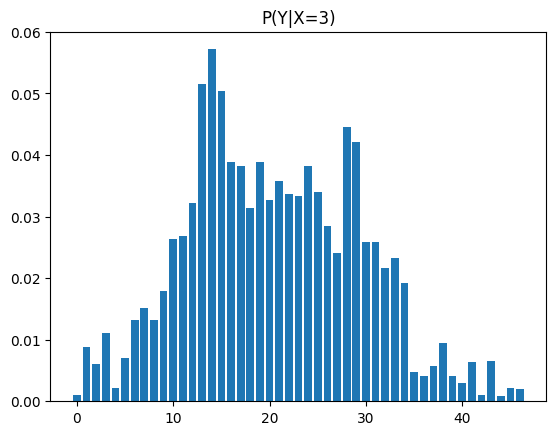

In [117]:
# Prediction for x=0
zero_preds = model(torch.tensor([3]).reshape([-1,1]).float().to(device)).softmax(dim=1)
# zero_preds.sort(descending=True, dim=1)
zero_preds_np = zero_preds.detach().cpu().numpy()
plt.title("P(Y|X=3)")
plt.bar(np.arange(zero_preds_np.shape[1]), height=zero_preds_np.reshape([-1]))

In [35]:
np.digitize(0, bin_edges) # Get the class of each point using histogram bins

22

In [119]:
# 3-headed output
# modification to MyModel
#    return output1, output2, output3 -> return self.net(x)  # torch.nn.Linear(30,3)
class QRegressor(torch.nn.Module):
    def __init__(self, in_size=1, out_size=1):
        super(QRegressor,self).__init__()
        self.in_size = in_size
        self.out_size = out_size

        hidden_layer = 64

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.in_size, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, 3*self.out_size)
            )

    def forward(self,x):
        return self.net(x)



In [120]:
def PinballLoss(input, target):
    ## Other Losses
    # Normal loss
    #loss = (((input[0] - target)/torch.exp(input[1]))**2+input[1]).mean()
    # Laplace loss
    #loss = (torch.abs((input[0] - target)/torch.exp(input[1]))+input[1]).mean()
    # t-distribution loss
    #nu = 3
    #loss = ((nu + 1)/2*torch.log(1+((input[0] - target)/torch.exp(input[1]))**2/nu)+input[1]).mean()
    # print(input, target)

    ## Quantile Loss
    q1 = 0.05
    q2 = 0.5
    q3 = 0.95


    ## Keras quantile loss, https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/
    #e = y_p-y
    #return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

    ## Quantile Loss
    ## for q1, q2, q3
    #print(input.shape)
    #print(input[:,0:1].shape)
    #print(target.shape)
    e1 = input[:,0:1] - target # !!! if input[:,0]  -> shape = (1000,)
    e2 = input[:,1:2] - target
    e3 = input[:,2:3] - target
    eq1 = torch.max(q1*e1, (q1-1)*e1)
    eq2 = torch.max(q2*e2, (q2-1)*e2)
    eq3 = torch.max(q3*e3, (q3-1)*e3)

    #eq1 = torch.max(0.05*e1, (0.05-1)*e1)
    #eq2 = torch.max(0.5*e2, (0.5-1)*e2)
    #eq3 = torch.max(0.95*e3, (0.95-1)*e3)

    loss = (eq1 + eq2 + eq3).mean()

    return loss

In [121]:
train_y_tr.shape

torch.Size([10000, 47])

In [122]:
train_x_tr = train_x_tr.to(device)
train_y_scalar = train_y_scalar.to(device)

model = QRegressor().to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [123]:
for step in range(3000):
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    yqs = model(train_x_tr)
    loss = PinballLoss(input=yqs, target =train_y_scalar)
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % 1000 == 0:
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1000 loss=0.2111
epoch 2000 loss=0.2094
epoch 3000 loss=0.2084


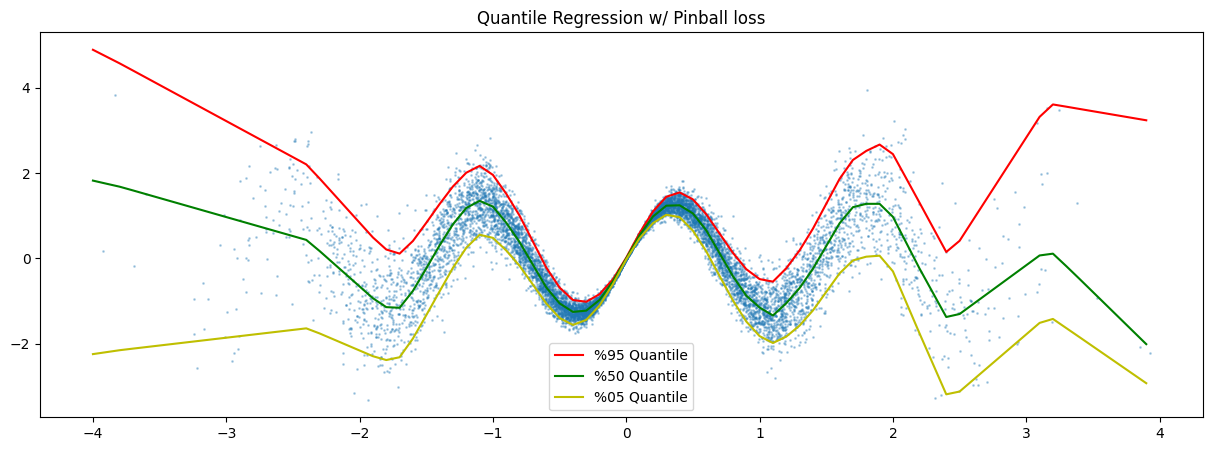

In [124]:
x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
y_pred = model(x_pred.to(device))

plt.figure(figsize=(15,5))

plt.title("Quantile Regression w/ Pinball loss")
plt.scatter(train_x, train_y, s=1, alpha=0.3)

plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,0], c='r', label="%95 Quantile")
plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,1], c='g', label="%50 Quantile")
plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,2], c='y', label="%05 Quantile")
plt.legend()

plt.show()

In [125]:
y_pred

tensor([[ 4.8884e+00,  1.8233e+00, -2.2418e+00],
        [ 4.7294e+00,  1.7515e+00, -2.1962e+00],
        [ 4.5705e+00,  1.6808e+00, -2.1506e+00],
        [ 4.4023e+00,  1.5934e+00, -2.1132e+00],
        [ 4.2332e+00,  1.5042e+00, -2.0767e+00],
        [ 4.0640e+00,  1.4151e+00, -2.0401e+00],
        [ 3.8948e+00,  1.3259e+00, -2.0036e+00],
        [ 3.7257e+00,  1.2367e+00, -1.9671e+00],
        [ 3.5565e+00,  1.1475e+00, -1.9306e+00],
        [ 3.3873e+00,  1.0583e+00, -1.8940e+00],
        [ 3.2182e+00,  9.6917e-01, -1.8575e+00],
        [ 3.0490e+00,  8.7999e-01, -1.8210e+00],
        [ 2.8798e+00,  7.9081e-01, -1.7845e+00],
        [ 2.7106e+00,  7.0163e-01, -1.7479e+00],
        [ 2.5415e+00,  6.1244e-01, -1.7114e+00],
        [ 2.3723e+00,  5.2326e-01, -1.6749e+00],
        [ 2.2031e+00,  4.3409e-01, -1.6384e+00],
        [ 1.8726e+00,  1.7332e-01, -1.7574e+00],
        [ 1.5272e+00, -1.0323e-01, -1.8908e+00],
        [ 1.1818e+00, -3.7977e-01, -2.0242e+00],
        [ 8.3636e-01

In [42]:
train_y

array([-0.43496885, -1.24701221, -1.01193887, ...,  0.72884625,
        1.41644938,  1.21039448])